In [1]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,log_loss

from sklearn.calibration import CalibratedClassifierCV

from data_filters import scout_service as sct
from maths.pitch import calculate_shots_coordinates, calculate_shots_on_target_coordinates
from maths.trig import calculate_angles
from plots import plot_confusion_matrix,plot_sensitivity_vs_specificity

#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [3]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

### Perguntas

* Porque o Events_ALL.gz tem a coluna index?
* Porque tem tantos valores duplicados da mesma jogada?
* Porque usou o head(100) nos dfs df_HS_predictor e df_HS_response?

In [4]:
# In[Running]
raw = pd.read_csv('database/2023/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
#raw.info()

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4917760 entries, 0 to 4943676
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Codigo                 int32  
 1   Lance                  object 
 2   Nome                   object 
 3   Ocorrencia             object 
 4   PosicaoLance           int32  
 5   TempoPartida           int32  
 6   TimestampStr           object 
 7   atleta_id              int32  
 8   apelido                object 
 9   sigla                  object 
 10  Jogador_Posicao        int32  
 11  Partida_CodigoExterno  float64
 12  tempo                  object 
 13  tempo_2                object 
 14  clube_id               int32  
 15  Codigo_SCT             float64
 16  Partida_CodigoInterno  float64
 17  Rodada                 int32  
 18  Torneio                object 
 19  Edicao                 float64
 20  oponente_id            int32  
 21  home_dummy             float64
 22  CampoPosicaoX     

In [6]:
raw

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,Torneio,Edicao,oponente_id,home_dummy,CampoPosicaoX,CampoPosicaoY,ContraAtaque,Metros,TravePosicaoX,TravePosicaoY
0,74,Passe,Completo,PT26S,13,1,2023-04-15T16:02:10,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74,Passe,Completo,PT35S,19,1,2023-04-15T16:02:18,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74,Passe,Completo,PT7M36S,26,1,2023-04-15T16:09:21,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74,Passe,Completo,PT8M11S,19,1,2023-04-15T16:09:55,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,Não Encontrado,Perda de Posse de Bola,PT12M34S,25,1,2023-04-15T16:14:20,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943672,25,Passe,Incompleto,PT51M5S,27,2,2023-11-12T20:28:42,117403,Renato Marques,ATA,...,Brasileiro,2023.0,267,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4943673,33,Arbitragem,Falta Cometida,PT51M8S,20,2,2023-11-12T20:28:45,89226,Iago Maidana,ZAD,...,Brasileiro,2023.0,267,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4943674,34,Arbitragem,Falta Recebida,PT51M9S,17,2,2023-11-12T20:28:45,99198,Vegetti,ATA,...,Brasileiro,2023.0,327,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4943675,74,Passe,Completo,PT51M44S,16,2,2023-11-12T20:29:20,69355,Medel,VOL,...,Brasileiro,2023.0,327,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

# o dataset contém muitos lances duplicados ,por isso precisamos dropar todos os que forem duplicados, mantendo somente a primeira aparição.
raw = raw.drop_duplicates(keep='first').reset_index(drop=True)
#print(raw.info())

## Coordenadas

- Mapear coordenadas de (x,y) no campo e no gol de px para metros
- Calcular o ângulo (degrees e radians) da coordenada (x,y) em relação ao gol


## Nomemclatura

- goal_x_px, goal_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- field_x_px, field_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- goal_x_metros, goal_y_metros -> coordenadas (x,y) em metros, para para o local onde foi feita a finalização
- field_x_metros, field_y_metros -> coordenadas (x,y) em metros, para o local onde foi feita a finalização

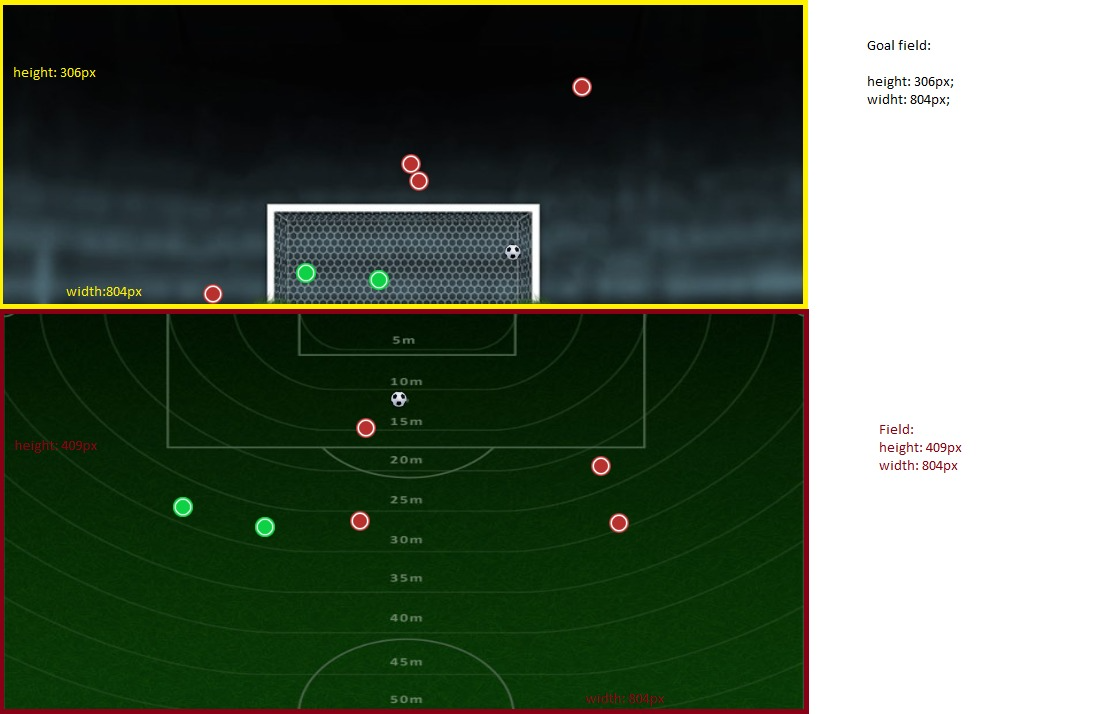

In [31]:
%matplotlib inline
from IPython.display import Image
Image('img/fields.png')

In [8]:
# filtragem por finalizações
df_shots_on_target = calculate_shots_on_target_coordinates(raw,'xGOT')
df_shots_on_target.to_csv('Shots_on_target.csv')
print(df_shots_on_target, df_shots_on_target.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7658 entries, 18 to 1003150
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Codigo                       7658 non-null   int64  
 1   Lance                        7658 non-null   object 
 2   Nome                         7658 non-null   object 
 3   Ocorrencia                   7658 non-null   object 
 4   PosicaoLance                 7658 non-null   int64  
 5   TempoPartida                 7658 non-null   int64  
 6   TimestampStr                 7658 non-null   object 
 7   atleta_id                    7658 non-null   int64  
 8   apelido                      7658 non-null   object 
 9   sigla                        7658 non-null   object 
 10  posicao_id                   7658 non-null   int64  
 11  match_id                     7658 non-null   float64
 12  tempo                        7658 non-null   object 
 13  tempo_2       

In [10]:
print ("Rows     : " ,df_shots_on_target.shape[0])
print ("Columns  : " ,df_shots_on_target.shape[1])
print ("\nFeatures : \n" ,df_shots_on_target.columns.tolist())
print ("\nUnique values :  \n",df_shots_on_target.nunique())
print ("\nMissing values :  ", df_shots_on_target.isnull().sum().values.sum())

Rows     :  7658
Columns  :  43

Features : 
 ['Codigo', 'Lance', 'Nome', 'Ocorrencia', 'PosicaoLance', 'TempoPartida', 'TimestampStr', 'atleta_id', 'apelido', 'sigla', 'posicao_id', 'match_id', 'tempo', 'tempo_2', 'clube_id', 'Codigo_SCT', 'match_id_sct', 'rodada_id', 'Torneio', 'Edicao', 'adversario_id', 'home_dummy', 'CampoPosicaoX', 'CampoPosicaoY', 'ContraAtaque', 'Metros', 'TravePosicaoX', 'TravePosicaoY', 'Goal', 'header_ot', 'goal_x_px_on_target', 'goal_y_px_on_target', 'field_x_px_on_target', 'field_y_px_on_target', 'goal_x_metros_on_target', 'goal_y_metros_on_target', 'field_x_metros_on_target', 'field_y_metros_on_target', 'Center_dist_on_target', 'xGOT_angle_radians', 'xGOT_angle_degrees', 'xGOT_vertical_angle_radians', 'xGOT_vertical_angle_degrees']

Unique values :  
 Codigo                            8
Lance                             3
Nome                              8
Ocorrencia                     2222
PosicaoLance                     22
TempoPartida                

In [11]:
# Convert 'TimestampStr' column to datetime
df_shots_on_target['Timestamp'] = pd.to_datetime(df_shots_on_target['TimestampStr'])
df_shots_on_target['year'] = df_shots_on_target['Timestamp'].dt.year
df_shots_on_target['month'] = df_shots_on_target['Timestamp'].dt.month
df_shots_on_target['day'] = df_shots_on_target['Timestamp'].dt.day

In [15]:
df_finalizacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 651443 to 1003200
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Codigo                     956 non-null    int64         
 1   Lance                      956 non-null    object        
 2   Nome                       956 non-null    object        
 3   Ocorrencia                 956 non-null    object        
 4   PosicaoLance               956 non-null    int64         
 5   TempoPartida               956 non-null    int64         
 6   TimestampStr               956 non-null    object        
 7   atleta_id                  956 non-null    int64         
 8   apelido                    956 non-null    object        
 9   sigla                      956 non-null    object        
 10  posicao_id                 956 non-null    int64         
 11  match_id                   956 non-null    float64       
 12 

### Fazer um recorte do dataframe após o início do provimento dos novos dados do Scout Service

Dados com 0.0 e -1 são faltantes

In [12]:
columns_to_check = ['goal_x_px_on_target', 'goal_y_px_on_target', 'field_x_px_on_target', 'field_y_px_on_target']
# Filter rows where all specified columns are not zero
df_shots_on_target = df_shots_on_target[~(df_shots_on_target[columns_to_check] == 0.0).all(axis=1)]

columns_to_check = ['Metros', 'Center_dist_on_target']
# Filter rows where all specified columns are not zero
df_shots_on_target = df_shots_on_target[~(df_shots_on_target[columns_to_check] == -1).all(axis=1)]

print(df_shots_on_target)


         Codigo               Lance                    Nome Ocorrencia  \
658178       13         Finalização  Fora da Área Defendido   PT20M58S   
658181       10         Finalização   Dentro Área Defendido    PT32M8S   
658182        8  Finalização Cabeça   Grande Área Defendido      PT36M   
658184       13         Finalização  Fora da Área Defendido     PT2M6S   
658185       10         Finalização   Dentro Área Defendido    PT2M17S   
...         ...                 ...                     ...        ...   
1002479       8  Finalização Cabeça   Grande Área Defendido   PT32M27S   
1002602       8  Finalização Cabeça   Grande Área Defendido   PT43M22S   
1002846      13         Finalização  Fora da Área Defendido    PT13M5S   
1003027      10         Finalização   Dentro Área Defendido   PT32M21S   
1003150      10         Finalização   Dentro Área Defendido   PT43M50S   

         PosicaoLance  TempoPartida         TimestampStr  atleta_id  \
658178             27             1  202

In [14]:
print(df_shots_on_target[['Center_dist_on_target','Metros']])

         Center_dist_on_target  Metros
658178                    25.0    25.0
658181                    15.0    15.0
658182                    10.0    10.0
658184                    30.0    30.0
658185                    15.0    15.0
...                        ...     ...
1002479                   10.0    10.0
1002602                   10.0    10.0
1002846                   20.0    20.0
1003027                    5.0     5.0
1003150                   10.0    10.0

[312 rows x 2 columns]


In [15]:
print(set(df_shots_on_target['Torneio']))
#df_finalizacoes.loc[(df_finalizacoes['Torneio']=='Brasileiro')&(df_finalizacoes['Edicao']==2022)&(df_finalizacoes['Rodada']==34)]
print(set(df_shots_on_target[df_shots_on_target['Torneio']=='Brasileiro']['Edicao']))


{'Brasileiro', 'Libertadores'}
{2023.0}


## Visualização Preliminar das Finalizações

In [13]:
#plot_distribution(df_finalizacoes)

In [14]:
#plot_violin_plot(df_finalizacoes)

In [17]:
# removendo linhas com valores ausentes 
df_shots_on_target = df_shots_on_target.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])

#convertendo as colunas 'header' e 'Goal' para valores numéricos
df_shots_on_target['header_ot'] = pd.to_numeric(df_shots_on_target['header_ot'])
df_shots_on_target['Goal'] = pd.to_numeric(df_shots_on_target['Goal'])

In [18]:
# removendo linhas com valores ausentes 
df_shots_on_target = df_shots_on_target.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])

#convertendo as colunas 'header' e 'Goal' para valores numéricos
df_shots_on_target['header_ot'] = pd.to_numeric(df_shots_on_target['header_ot'])
df_shots_on_target['Goal'] = pd.to_numeric(df_shots_on_target['Goal'])
    
#choose specific goals and misses

#Selecionando índices onde houve um gol (Goal==1) e a distância é menor que 12 unidades.
idx_goal = np.where((df_shots_on_target['Goal']==1) & (df_shots_on_target['Metros'] < 12)) 

# criando um novo DataFrame df_HS_goal contendo as linhas selecionadas de acordo com idx_goal.
df_HS_goal = df_shots_on_target.iloc[idx_goal]

# selecionando índices onde não houve gol (Goal==0) e a distância é maior que 13 unidades.
idx_miss = np.where((df_shots_on_target['Goal']==0) & (df_shots_on_target['Metros']> 13)) 

#riando um novo DataFrame df_HS_miss contendo as linhas selecionadas de acordo com idx_miss
df_HS_miss = df_shots_on_target.iloc[idx_miss]


#criando arrays numpy contendo os valores de distância e gol/marcador para os casos de gol e não gol. Parece que você está preparando esses dados para usar em algum tipo de análise ou plotagem posterior.
#plot the heaviside function on top of the responses for the seperable data above
#df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
#df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

In [55]:
#df_HS_goal

In [18]:
#plot_heavside(df_HS_goal,df_HS_miss)

In [19]:
#plot_shots()

In [20]:

#Encontrar os índices das linhas em que ocorreram gols (Goal==1) e a distância é menor que 25 unidades
idx = np.where((df_shots_on_target['Goal']==1) & (df_shots_on_target['Metros'] < 25)) 

#criando um novo DataFrame chamado df_log_goal que contém as linhas selecionadas com base nos índices obtidos anteriormente
df_log_goal = df_shots_on_target.iloc[idx]

#encontrar os índices das linhas em que não ocorreram gols (Goal==0) e a distância é maior que 5 unidades.
idx = np.where((df_shots_on_target['Goal']==0) & (df_shots_on_target['Metros']> 5)) 

#criando um novo DataFrame chamado df_log_miss que contém as linhas selecionadas com base nos novos índices obtidos.
df_log_miss = df_shots_on_target.iloc[idx]

In [21]:
#plot_goal_miss(df_finalizacoes, df_log_goal, df_log_miss)

## O modelo xG

Nosso objetivo é criar um modelo para descrever com precisão nossos dados existentes da melhor forma possível e, eventualmente, prever eventos futuros. Antes de aplicar a regressão logística a todo o nosso conjunto de dados, devemos dividir nossos dados em conjuntos de treinamento e teste. O conjunto de treinamento serve aos dados sobre os quais construímos nosso modelo, e o conjunto de teste são os dados que usamos para avaliar o desempenho de nosso modelo. Ajustar os dados de treinamento à função logística produzirá coeficientes para nossos preditores (farei isso usando a biblioteca Scikit-learn em Python). Se começarmos ajustando apenas a variável de distância, devemos chegar aos parâmetros ideais para descrever os dados de treinamento:

### Estudo 1 - Distância do Chute

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [21]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # container pra todas as probabilidades do dataset
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        precision_scores = []  # List to store precision scores

        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para teste e o resto 
        # para treino (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit apenas no conjunto de treino:
            scaler.fit(X[treino])
            # Vamos escalar tanto os dados de treino quanto de teste.
            X_treino_escalado = scaler.transform(X[treino])
            X_teste_escalado = scaler.transform(X[teste])
            # Fit do modelo nos dados de treino:
            modelo.fit(X_treino_escalado, y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X_teste_escalado)                    
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            precision_scores.append(precision_score(y[teste], y_pred))  # Calculate precision
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X_teste_escalado)
            # logistic regression predicts probability for both classes; pick only class '1'
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score[:, 1]))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Precisao"].append(np.mean(precision_scores))  # Add precision average to results
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [23]:
X = df_shots_on_target[['Metros','xGOT_angle_degrees','header_ot']].copy().values
y = df_shots_on_target[['Goal']].values.reshape(-1)

print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Precisao" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }
# avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)


# definindo as diferentes configurações para o método NB
modelos_gaussian = {
    "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
    "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
    "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
    "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
    "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
}

avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# definindo as diferentes configurações para o método KNN

modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11),
}

avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(312, 3)
(312,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametrização

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.7820564516129032,
  0.6215725806451612,
  0.6534274193548388,
  0.750100806451613,
  0.7533266129032259,
  0.7566532258064517,
  0.7306451612903226,
  0.7177419354838711,
  0.7177419354838711,
  0.7177419354838711,
  0.7177419354838711,
  0.7177

In [24]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Precisao,Roc_auc
0,Logistic Regression,Logistic Regression,0.782056,0.575595,0.530000,0.716741
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.621573,0.659821,0.347240,0.726042
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.653427,0.640179,0.353234,0.712202
3,XGBoost,XGBoost Default,0.750101,0.604464,0.477183,0.707068
4,XGBoost,"XGBoost with max_depth=3, learning_rate=0.1",0.753327,0.566964,0.477302,0.722024
5,XGBoost,"XGBoost with subsample=0.7, colsample_bytree=0.8",0.756653,0.604464,0.440357,0.700446
6,XGBoost,XGBoost with scale_pos_weight for imbalanced,0.730645,0.619643,0.462165,0.730208
7,GaussianNB,Var smoothing 1e-9,0.717742,0.589583,0.414091,0.714063
8,GaussianNB,Var smoothing 1e-8,0.717742,0.589583,0.414091,0.714063
9,GaussianNB,Var smoothing 1e-7,0.717742,0.589583,0.414091,0.714063


In [35]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
GaussianNB,0.714063
KNN,0.713467
Logistic Regression,0.726042
XGBoost,0.730208


In [36]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='GaussianNB', Roc_auc=0.7140625)
Melhor parametrização do GaussianNB = Var smoothing 1e-9
Pandas(Index='KNN', Roc_auc=0.713467261904762)
Melhor parametrização do KNN = N=11
Pandas(Index='Logistic Regression', Roc_auc=0.7260416666666668)
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False
Pandas(Index='XGBoost', Roc_auc=0.7302083333333333)
Melhor parametrização do XGBoost = XGBoost with scale_pos_weight for imbalanced


In [37]:
!pip install xgboost

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [53]:
def logistic_regression_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset
    dataset = df[['Goal','Metros','xGOT_angle_degrees','header_ot']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal',axis=1), 
                                                        dataset['Goal'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

#     # escalar os dados
#     scaler = StandardScaler()

#     # Fit apenas no conjunto de treino:
#     scaler.fit(X_train)

#     # Vamos escalar tanto os dados de treino quanto de teste.
#     X_treino_escalado = scaler.transform(X_train)
#     X_teste_escalado = scaler.transform(X_test)

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Goal',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xGOT'] = y_hat
    return df

In [54]:
# def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):
#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     # Inicializar o dataset
#     dataset = df[['Goal','Distance','Angle Radians','header']].copy()

#     # Dividir em treino e teste
#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), 
#                                                         dataset['Goal'], test_size=0.20, 
#                                                         random_state=10)

#     # Inicializar o modelo XGBoost
#     xgb_model = XGBClassifier()

#     # Treinar o modelo
#     xgb_model.fit(X_train, y_train)

#     # Fazer previsões no conjunto de teste
#     y_pred = xgb_model.predict(X_test)

#     # Avaliar a precisão do modelo
#     accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy:", accuracy)

#     # Fazer previsões no conjunto completo
#     y_probs = xgb_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

#     # Adicionar probabilidades xG ao DataFrame original
#     df['xG'] = y_probs

#     return df

def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):

    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    dataset = df[['Goal','Metros','xGOT_angle_degrees','header_ot']].copy()
    dataset['Metros*xGOT_angle_degrees'] = dataset['Metros'] * dataset['xGOT_angle_degrees']

    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), dataset['Goal'], test_size=0.20, random_state=10)

    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
    calibrated_clf.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Log Loss:", logloss)
    print("AUC:", auc)

    y_probs = calibrated_clf.predict_proba(dataset.drop('Goal', axis=1))[:, 1]
    df['xGOT'] = y_probs

    return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [57]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
#df_geral = xgboost_xG(df=df_shots_on_target)
df_geral = logistic_regression_xG(df=df_shots_on_target)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro = df_geral.loc[(df_shots_on_target['Torneio']=='Brasileiro')&(df_shots_on_target['Edicao']==2023)]

In [58]:
#df_geral.to_csv('/Users/vitor.patalano/Documents/globo/gato_mestre/betting/database/footstats/xG.csv', index=False)

In [59]:
df_brasileiro = df_brasileiro.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [60]:
df_brasileiro.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro['rodada_id'].max()
print(rodada)

34


In [61]:
df_brasileiro['rodada_id'].nunique()

4

In [62]:
df_brasileiro[df_brasileiro['clube_id']==262]['rodada_id'].nunique()

4

### Trazer Dataset Cartola

In [63]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2023/Cartola_2023_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [64]:
times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

times_dict_r = {v:k for k, v in times_dict.items()}
clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Santos':'![Santos](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/santos_60x60.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athlético-PR':'![Athlético-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'América-MG':' ![América-MG](https://s.glbimg.com/es/sde/f/organizacoes/2019/02/28/escudo65_1.png)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Coritiba':'![Coritiba](https://s.glbimg.com/es/sde/f/organizacoes/2017/03/29/coritiba65.png)',
'Goiás':'![Goiás](https://s.glbimg.com/es/sde/f/organizacoes/2019/05/01/Goias_65px.png)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }

### Trazer mando de campo a partir das partidas

In [65]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xGOT Clubes
Calcular o xGOT agregado por clubes.

- somar o xGOT total
- somar o xGOT por partida
- calcular a média por partida
- comparar total vs média

In [66]:
df_brasileiro

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,xGOT_angle_radians,xGOT_angle_degrees,xGOT_vertical_angle_radians,xGOT_vertical_angle_degrees,Timestamp,year,month,day,xG,xGOT
658178,13,Finalização,Fora da Área Defendido,PT20M58S,27,1,2023-11-02T20:23:47,91689,Matheus Jussa,VOL,...,0.158550,9.084254,0.739975,42.397438,2023-11-02 20:23:47,2023,11,2,0.101491,0.101491
658181,10,Finalização,Dentro Área Defendido,PT32M8S,33,1,2023-11-02T20:32:50,69063,James Rodríguez,MEC,...,0.124900,7.156225,0.573919,32.883138,2023-11-02 20:32:50,2023,11,2,0.168935,0.168935
658182,8,Finalização Cabeça,Grande Área Defendido,PT36M,33,1,2023-11-02T20:38:48,90309,David,ATA,...,0.091860,5.263165,0.532022,30.482614,2023-11-02 20:38:48,2023,11,2,0.225469,0.225469
658184,13,Finalização,Fora da Área Defendido,PT2M6S,30,2,2023-11-02T21:11:46,89275,William,LAD,...,0.087088,4.989767,0.526878,30.187881,2023-11-02 21:11:46,2023,11,2,0.163814,0.163814
658185,10,Finalização,Dentro Área Defendido,PT2M17S,34,2,2023-11-02T21:10:48,91689,Matheus Jussa,VOL,...,0.085230,4.883313,0.500415,28.671645,2023-11-02 21:10:48,2023,11,2,0.229035,0.229035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002479,8,Finalização Cabeça,Grande Área Defendido,PT32M27S,34,1,2023-11-12T19:03:44,102561,Mastriani,ATA,...,0.043967,2.519146,0.530581,30.400078,2023-11-12 19:03:44,2023,11,12,0.315181,0.315181
1002602,8,Finalização Cabeça,Grande Área Defendido,PT43M22S,34,1,2023-11-12T19:14:44,102561,Mastriani,ATA,...,0.060021,3.438966,0.452317,25.915835,2023-11-12 19:14:44,2023,11,12,0.283015,0.283015
1002846,13,Finalização,Fora da Área Defendido,PT13M5S,27,2,2023-11-12T19:53:47,95662,Lucas Kal,VOL,...,0.137560,7.881613,0.643040,36.843470,2023-11-12 19:53:47,2023,11,12,0.136208,0.136208
1003027,10,Finalização,Dentro Área Defendido,PT32M21S,34,2,2023-11-12T20:10:21,99198,Vegetti,ATA,...,0.020330,1.164833,0.545541,31.257202,2023-11-12 20:10:21,2023,11,12,0.418895,0.418895


In [67]:
# xG total
df_clubes_xgot_total = df_brasileiro.groupby(['clube_id'])['xGOT'].agg([('xGOT_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xgot_match = df_brasileiro.groupby(['clube_id','rodada_id'])['xGOT'].agg([('xGOT_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xgot_mean = df_clubes_xgot_match.groupby('clube_id')['xGOT_sum'].agg([('xGOT_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xgot_std = df_brasileiro.groupby('clube_id')['xGOT'].agg([('xGOT_std',np.std)]).reset_index()
# gols
df_clubes_g_total = df_cartola.groupby('clube_id')['G'].agg([('G_total','sum')]).reset_index()
# merge
df_clubes_xgot = df_clubes_xgot_total.merge(df_clubes_xgot_mean, on='clube_id')
# merge again
df_clubes_xgot_vs_g = df_clubes_xgot.merge(df_clubes_g_total, on='clube_id')
# and again
df_clubes_xgot_vs_g = df_clubes_xgot_vs_g.merge(df_clubes_xgot_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xgot_vs_g['clube'] = df_clubes_xgot_vs_g['clube_id'].map(times_dict_r)
df_clubes_xgot_vs_g['clube'] = df_clubes_xgot_vs_g['clube'].map(team_icons)
# sort por média xG
df_clubes_xgot_vs_g = df_clubes_xgot_vs_g.sort_values(by='xGOT_total',ascending=False).reset_index(drop=True)[['clube', 'xGOT_mean', 'xGOT_total','G_total']]
df_clubes_xgot_vs_g.dropna()

#df_clubes_xg_vs_g.to_csv(f'conteudo/xG_vs_Goals_R{rodada}.csv', index=False)

df_clubes_xgot_vs_g

,clube,xGOT_mean,xGOT_total,G_total
0,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.311749,5.246996,55.0
1,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.272382,5.089528,43.0
2,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.183633,4.734533,49.0
3,![Goiás](https://s.glbimg.com/es/sde/f/organiz...,1.151834,4.607336,33.0
4,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.142308,4.569234,51.0
5,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.121137,4.484547,35.0
6,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.097347,4.389387,52.0
7,![Corinthians](https://s.glbimg.com/es/sde/f/o...,0.943427,3.773710,33.0
8,![Santos](https://s.glbimg.com/es/sde/f/organi...,0.782852,3.131409,33.0
9,![América-MG](https://s.glbimg.com/es/sde/f/o...,1.029883,3.089649,39.0


# Expected Points (xP)

Quanto se esperaria que estivesse a tabela do campeonato de acordo com xG

In [66]:
def confrontos_xG(df_brasileiro):
    confrontos_xg = df_brasileiro.groupby(['clube_id', 'adversario_id'])['xG'].agg([('xG_sum','sum')]).reset_index()

    df_confrontos_xg = confrontos_xg.merge(
                                        confrontos_xg.set_index(['adversario_id','clube_id']),
                                        left_on=['clube_id','adversario_id'],
                                        right_index=True,
                                        suffixes=('_clube','_adversario'),
                                        how='left'
                                    )
    df_confrontos_xg['clube'] = df_confrontos_xg['clube_id'].map(times_dict_r)
    df_confrontos_xg['adversario'] = df_confrontos_xg['adversario_id'].map(times_dict_r)
    return df_confrontos_xg

confrontos_xG(df_brasileiro)

,clube_id,adversario_id,xG_sum_clube,xG_sum_adversario,clube,adversario
0,0,0,3.473834,3.473834,NaN,NaN
1,262,263,3.215694,2.050704,Flamengo,Botafogo
2,262,264,0.500392,0.244743,Flamengo,Corinthians
3,262,265,2.110955,1.034400,Flamengo,Bahia
4,262,266,0.634139,1.909071,Flamengo,Fluminense
...,...,...,...,...,...,...
370,1371,290,1.160547,0.149570,Cuiabá,Goiás
371,1371,293,0.248475,2.391037,Cuiabá,Athlético-PR
372,1371,294,0.081315,0.590190,Cuiabá,Coritiba
373,1371,327,0.457003,0.317137,Cuiabá,América-MG


# xGOT Atletas

#### Agora vamos fazer o cálculo de xGOT etc sob a perspectiva dos atletas

- Estudo 01. xGOT total
- Estudo 02. xGOT por jogo
- Estudo 03. xGOT vs gols
- Estudo 04. xGOT como medida de eficiência
- Estudo 05. xGOT como medida de potencial

## xGOT Total

In [68]:
df_atletas = df_brasileiro.groupby(['atleta_id', 'apelido','clube_id'])['xGOT'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xGOT',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xGOT']]
df_atletas.head(30)

,apelido,clube_id,clube,xGOT
0,Pedro,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,2.298656
1,Luis Suárez,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.720236
2,Thiago Borbas,280,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.714202
3,Paulinho,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,1.618249
4,Júnior Santos,263,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.402041
5,Raphael Veiga,275,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.205622
6,Ángel Romero,264,![Corinthians](https://s.glbimg.com/es/sde/f/o...,1.166727
7,Mastriani,327,![América-MG](https://s.glbimg.com/es/sde/f/o...,1.136612
8,Everaldo,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.134455
9,Helinho,280,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.125749


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [ ]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xG_total=('xG', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xG_per_match']=df_atletas2['xG_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xG_per_shot'] = df_atletas2['xG_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xG_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,12.526746,46,14,13,0.894768,0.928571,0.272321,3.538462,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,109497,Marcos Leonardo,277,7.230233,31,13,7,0.556172,0.538462,0.233233,4.428571,![Santos](https://s.glbimg.com/es/sde/f/organi...
2,92708,Deyverson,1371,7.048478,34,14,8,0.503463,0.571429,0.207308,4.250000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...
3,114802,Vitor Roque,293,6.870238,38,13,8,0.528480,0.615385,0.180796,4.750000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
4,79631,Cano,266,5.508308,41,15,6,0.367221,0.400000,0.134349,6.833333,![Fluminense](https://s.glbimg.com/es/sde/f/or...
5,106199,Gabriel Pec,267,5.195757,37,15,3,0.346384,0.200000,0.140426,12.333333,![Vasco](https://s.glbimg.com/es/sde/f/organiz...
6,69318,Luis Suárez,284,5.134843,60,15,4,0.342323,0.266667,0.085581,15.000000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
7,89898,Róger Guedes,264,4.917861,43,13,6,0.378297,0.461538,0.114369,7.166667,![Corinthians](https://s.glbimg.com/es/sde/f/o...
8,39148,Hulk,282,4.801700,66,17,7,0.282453,0.411765,0.072753,9.428571,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
9,94583,Pedro,262,4.542776,23,13,5,0.349444,0.384615,0.197512,4.600000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...


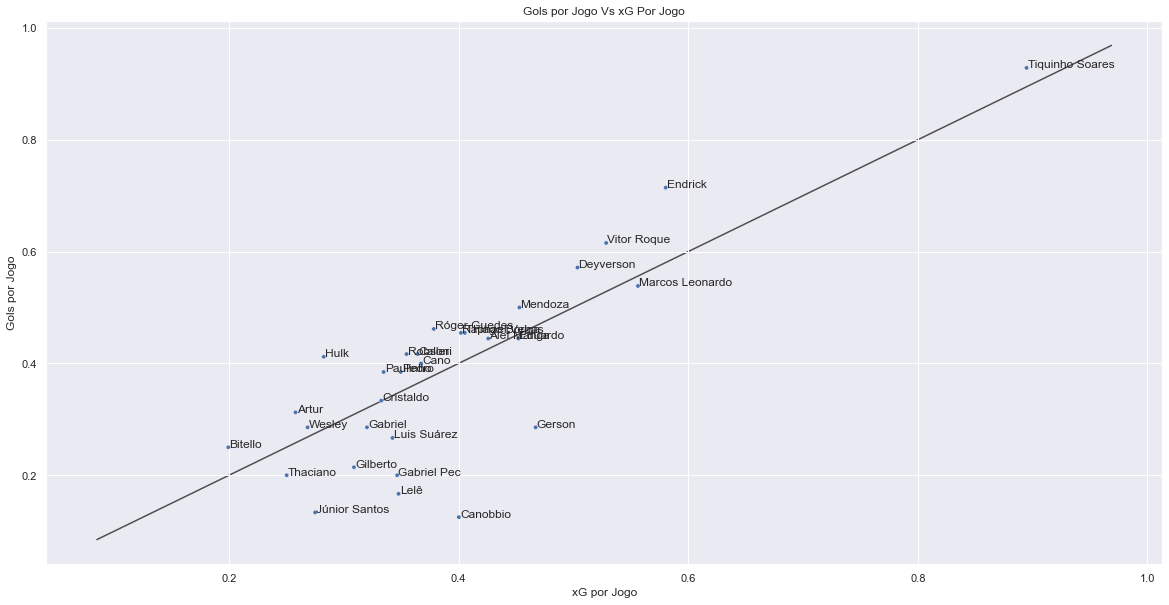

In [ ]:
def xG_fit(df,rodada):
    # pegar apenas 30
    df = df.head(30)
    # # obter médias para o tracejado nos eixos
    # xG_geral_mean = np.mean(list(df['xG_geral'].values))
    # xGA_geral_mean = np.mean(list(df['xGA_geral'].values))
    
    #sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xG_per_match', # Horizontal axis
       'G_per_match', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    
    plt.title('Gols por Jogo Vs xG Por Jogo')
    # Set x-axis label
    plt.xlabel('xG por Jogo')
    # Set y-axis label
    plt.ylabel('Gols por Jogo')
    
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.001, point['y'], str(point['val']))
            #ax.plot([-1,1],[-1,1], 'red', linewidth=10)

            
    label_point(df.xG_per_match, df.G_per_match, df.apelido, plt.gca())  

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    
    fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')
    
xG_fit(xg_total,rodada)

## xG per match

In [318]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

7.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,12.526746,46,14,13,0.894768,0.928571,0.272321,3.538462,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,115959,Endrick,275,4.062495,13,7,5,0.580356,0.714286,0.312500,2.600000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
2,109497,Marcos Leonardo,277,7.230233,31,13,7,0.556172,0.538462,0.233233,4.428571,![Santos](https://s.glbimg.com/es/sde/f/organi...
3,114802,Vitor Roque,293,6.870238,38,13,8,0.528480,0.615385,0.180796,4.750000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
4,92708,Deyverson,1371,7.048478,34,14,8,0.503463,0.571429,0.207308,4.250000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...
5,89256,Gerson,262,3.269062,13,7,2,0.467009,0.285714,0.251466,6.500000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
6,90031,Mendoza,277,4.528296,27,10,5,0.452830,0.500000,0.167715,5.400000,![Santos](https://s.glbimg.com/es/sde/f/organi...
7,68708,Eduardo,263,4.067351,15,9,4,0.451928,0.444444,0.271157,3.750000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
8,101254,Alef Manga,294,3.831593,27,9,4,0.425733,0.444444,0.141911,6.750000,![Coritiba](https://s.glbimg.com/es/sde/f/orga...
9,117314,Thiago Borbas,280,4.458341,24,11,5,0.405304,0.454545,0.185764,4.800000,![Bragantino](https://s.glbimg.com/es/sde/f/or...


In [319]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)



## xG vs Gols

Um estudo comparativo entre Gols e Expected Gols pode ser visto sob dois prismas:

- Eficiência
- Potencial

### 'Eficiência' mede, a partir da diferença entre uma métrica e outra, o nível de aproveitamento dos atletas.

In [320]:
df_atletas2['eficiência'] = df_atletas2['goals_total']-df_atletas2['xG_total']
df_eficiencia = df_atletas2.loc[df_atletas2['goals_total']>=1].sort_values(by='eficiência',ascending=False).reset_index(drop=True).head(50)
df_eficiencia.dropna()

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,70360,Eduardo Sasha,280,1.421711,25,14,5,0.101551,0.357143,0.056868,5.000000,![Bragantino](https://s.glbimg.com/es/sde/f/or...,3.578289
1,39148,Hulk,282,4.801700,66,17,7,0.282453,0.411765,0.072753,9.428571,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.198300
2,91607,Rony,275,2.086108,20,10,4,0.208611,0.400000,0.104305,5.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.913892
3,87863,Arrascaeta,262,1.163226,23,10,3,0.116323,0.300000,0.050575,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.836774
4,106002,Johnny,285,0.248407,9,7,2,0.035487,0.285714,0.027601,4.500000,![Internacional](https://s.glbimg.com/es/sde/f...,1.751593
5,89918,Everton Galdino,284,0.252649,8,7,2,0.036093,0.285714,0.031581,4.000000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.747351
6,91473,Erick Pulgar,262,0.253468,5,4,2,0.063367,0.500000,0.050694,2.500000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.746532
7,106202,Bruno Gomes,294,0.281831,23,11,2,0.025621,0.181818,0.012254,11.500000,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,1.718169
8,80287,Luciano,276,2.283035,35,12,4,0.190253,0.333333,0.065230,8.750000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.716965
9,106704,Carlos Alberto,263,0.366813,3,3,2,0.122271,0.666667,0.122271,1.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.633187


In [321]:
df_eficiencia = df_eficiencia[['apelido','clube','xG_total','goals_total','xG_per_match','G_per_match','shots_per_goal']]
df_eficiencia.head(20).to_csv(f'conteudo/Eficiencia_ate_R{rodada}.csv', index=False)
df_eficiencia

,apelido,clube,xG_total,goals_total,xG_per_match,G_per_match,shots_per_goal
0,Eduardo Sasha,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.421711,5,0.101551,0.357143,5.000000
1,Hulk,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,4.801700,7,0.282453,0.411765,9.428571
2,Rony,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,2.086108,4,0.208611,0.400000,5.000000
3,Arrascaeta,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.163226,3,0.116323,0.300000,7.666667
4,Johnny,![Internacional](https://s.glbimg.com/es/sde/f...,0.248407,2,0.035487,0.285714,4.500000
5,Everton Galdino,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,0.252649,2,0.036093,0.285714,4.000000
6,Erick Pulgar,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.253468,2,0.063367,0.500000,2.500000
7,Bruno Gomes,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,0.281831,2,0.025621,0.181818,11.500000
8,Luciano,![São Paulo](https://s.glbimg.com/es/sde/f/org...,2.283035,4,0.190253,0.333333,8.750000
9,Carlos Alberto,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,0.366813,2,0.122271,0.666667,1.500000


### 'Potencial' mede, por outro lado, aqueles atletas que tem maior potencial de crescimento
Se invertermos o ranking, vemos quem está no topo do aproveitamente abaixo do esperado, ou seja, com maiores possibilidades de convergência para a expectativa

In [322]:
# note: ascending = True
df_potencial = df_atletas2.loc[df_atletas2['goals_total']>=1].head(20).sort_values(by='eficiência',ascending=True).reset_index(drop=True)
df_potencial

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,61188,Gilberto,283,4.322539,34,14,3,0.308753,0.214286,0.127133,11.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...,-1.322539
1,38279,Wellington Paulista,327,1.575501,9,4,1,0.393875,0.250000,0.175056,9.000000,![América-MG](https://s.glbimg.com/es/sde/f/o...,-0.575501
2,69102,Vargas,282,1.250635,5,3,1,0.416878,0.333333,0.250127,5.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,-0.250635
3,50347,Alan Kardec,282,1.109506,5,3,1,0.369835,0.333333,0.221901,5.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,-0.109506
4,68708,Eduardo,263,4.067351,15,9,4,0.451928,0.444444,0.271157,3.750000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,-0.067351
5,42116,Willian,293,2.027280,4,4,2,0.506820,0.500000,0.506820,2.000000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,-0.027280
6,69138,Pablo,293,2.958359,20,9,3,0.328707,0.333333,0.147918,6.666667,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,0.041641
7,52827,David Luiz,262,0.905579,5,4,1,0.226395,0.250000,0.181116,5.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.094421
8,38398,Renato Augusto,264,0.835228,7,5,1,0.167046,0.200000,0.119318,7.000000,![Corinthians](https://s.glbimg.com/es/sde/f/o...,0.164772
9,51772,Everton Ribeiro,262,1.676569,14,10,2,0.167657,0.200000,0.119755,7.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.323431


In [105]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3886 entries, 101919 to 275553
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Codigo         3886 non-null   int64  
 1   Lance          3886 non-null   object 
 2   Nome           3886 non-null   object 
 3   Ocorrencia     3886 non-null   object 
 4   PosicaoLance   3886 non-null   int64  
 5   TempoPartida   3886 non-null   int64  
 6   TimestampStr   3886 non-null   object 
 7   atleta_id      3886 non-null   int64  
 8   apelido        3886 non-null   object 
 9   sigla          3886 non-null   object 
 10  posicao_id     3886 non-null   int64  
 11  match_id       3886 non-null   float64
 12  tempo          3886 non-null   object 
 13  tempo_2        3886 non-null   object 
 14  clube_id       3886 non-null   int64  
 15  Codigo_SCT     3886 non-null   float64
 16  match_id_sct   3886 non-null   float64
 17  rodada_id      3886 non-null   int64  
 18  T

In [104]:
# def xG_geral(df, row):
#     # Geral
#     conquistado_geral = df[(df['rodada_id']<=row['rodada_id']) & \
#                            (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_geral[0]

# def xG_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     conquistado_mandante_posicao = df[(df['home_dummy']==1) & \
#                                       (df['clube_id']==row['clube_id']) & \
#                                       (df['rodada_id']<=row['rodada_id']) & \
#                                       (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_mandante_geral = df[(df['home_dummy']==1) & \
#                                     (df['rodada_id']<=row['rodada_id']) & \
#                                     (df['clube_id']==row['clube_id'])][['xG']].mean()
#     # Visitante
#     # Posicao
#     conquistado_visitante_posicao = df[(df['home_dummy']==0) & \
#                                        (df['clube_id']==row['clube_id']) & \
#                                        (df['rodada_id']<=row['rodada_id']) & \
#                                        (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_visitante_geral = df[(df['home_dummy']==0) & \
#                                      (df['rodada_id']<=row['rodada_id']) & \
#                                      (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_mandante_posicao[0], conquistado_mandante_geral[0], conquistado_visitante_posicao[0], conquistado_visitante_geral[0]

# # xG allowed
# def xGA_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     cedido_mandante_posicao = df[(df['home_dummy']==0) & \
#                                  (df['adversario_id']==row['equipe_id']) & \
#                                  (df['rodada_id']<=row['rodada_id']) & \
#                                  (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_mandante_geral = df[(df['home_dummy']==0) & \
#                                (df['rodada_id']<=row['rodada_id']) & \
#                                (df['adversario_id']==row['equipe_id'])][['xG']].mean()

#     # Visitante
#     # Posicao
#     cedido_visitante_posicao = df[(df['home_dummy']==1) & \
#                                   (df['adversario_id']==row['equipe_id']) & \
#                                   (df['rodada_id']<=row['rodada_id']) & \
#                                   (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_visitante_geral = df[(df['home_dummy']==1) & \
#                                 (df['rodada_id']<=row['rodada_id']) & \
#                                 (df['adversario_id']==row['equipe_id'])][['xG']].mean()


#     return cedido_mandante_posicao[0], cedido_mandante_geral[0], cedido_visitante_posicao[0], cedido_visitante_geral[0]

# df_brasileiro['xg_mando_pos'] = df_brasileiro.apply(lambda x: xG_mando_posicao(df_brasileiro, x))
# #print (df_brasileiro.query('rodada_id >= 1')[('sum', 'xG')].mean())